In [1]:
import dask.dataframe as dd
import duckdb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.pyensembl_operations import import_pyensembl
import sqlite3
from scipy.stats import poisson
from statsmodels.stats.multitest import fdrcorrection

pd.set_option('display.max_columns', None)   # Show all columns

# Initialize pyensembl
g37 = import_pyensembl(37)

# For DuckDB queries
real_files = "read_csv_auto('results/dec7_combined.csv')" 
synth_files = "read_parquet('results/processed/synth/**/*.parquet')"

INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/nazif/thesis/data/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/nazif/thesis/data/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /home/nazif/thesis/data/pyensembl/GRCh37/ensembl75/Homo_sapiens.GRCh37.75.pep.all.fa.gz.pickle


In [2]:
def pivot_counts(df):
    """Pivot a given DataFrame with upreg counts."""
    result = (df.groupby(['gene_id', 'is_gene_upregulated'])
              .size()
              .reset_index()
              .compute())

    result = (result.pivot(index='gene_id', 
                           columns='is_gene_upregulated', 
                           values=0)
              .fillna(0)
              .reset_index())

    result.columns = ['gene_id', 'downreg_count', 'upreg_count']

    return result

def get_common_genes(real_files, synth_files):
    """Get common gene_ids from real and synthetic files."""
    query_real_genes = f"""
        SELECT DISTINCT gene_id
        FROM {real_files}
        WHERE vcf_id != 'PD4120a' 
        AND gene_id != 'not_found'
    """

    query_synth_genes = f"""
        SELECT DISTINCT gene_id
        FROM {synth_files}
        WHERE vcf_id != 'PD4120a' 
        AND gene_id != 'not_found'
    """

    genes_in_real = set(duckdb.sql(query_real_genes).df()['gene_id'])
    genes_in_synth = set(duckdb.sql(query_synth_genes).df()['gene_id'])

    return genes_in_real.intersection(genes_in_synth)

def analyze_mirna_binding_changes(results_merged):
    result_cols = ['gene_id', 'upreg_count_real', 'downreg_count_real', 
                  'upreg_count_synth', 'downreg_count_synth']
    
    results = results_merged[result_cols].copy()
    
    # Normalize synthetic
    results['upreg_synth_norm'] = results['upreg_count_synth'] / 10
    results['downreg_synth_norm'] = results['downreg_count_synth'] / 10
    
    # Effect sizes with epsilon
    epsilon = 1e-10
    results['log2fc_new_sites'] = np.log2((results['downreg_count_real'] + epsilon) / 
                                         (results['downreg_synth_norm'] + epsilon))
    results['log2fc_lost_sites'] = np.log2((results['upreg_count_real'] + epsilon) / 
                                          (results['upreg_synth_norm'] + epsilon))
    
    # Z-scores with handling for zeros
    def safe_z_score(observed, expected):
        if expected == 0:
            return 0 if observed == 0 else np.inf * np.sign(observed)
        return (observed - expected) / np.sqrt(max(expected, epsilon))
    
    results['z_score_new_sites'] = results.apply(
        lambda row: safe_z_score(row['downreg_count_real'], row['downreg_synth_norm']), axis=1)
    results['z_score_lost_sites'] = results.apply(
        lambda row: safe_z_score(row['upreg_count_real'], row['upreg_synth_norm']), axis=1)
    
    # Rest of the code remains same...
    def poisson_test(row):
        p_new = 1 - poisson.cdf(row['downreg_count_real'], max(row['downreg_synth_norm'], epsilon))
        p_lost = 1 - poisson.cdf(row['upreg_count_real'], max(row['upreg_synth_norm'], epsilon))
        return min(p_new, p_lost)
    
    results['pvalue'] = results.apply(poisson_test, axis=1)
    _, results['adjusted_pvalue'] = fdrcorrection(results['pvalue'])
    
    return results


def add_filter_columns(results_df):
    # Significance filter
    results_df['is_significant'] = results_df['adjusted_pvalue'] < 0.05
    
    # Strong effect filters (|z| > 2)
    results_df['strong_new_sites'] = abs(results_df['z_score_new_sites']) > 2
    results_df['strong_lost_sites'] = abs(results_df['z_score_lost_sites']) > 2
    
    # One-way pattern
    results_df['is_one_way'] = (results_df['strong_new_sites'] ^ results_df['strong_lost_sites']) & results_df['is_significant']
    
    # Direction specific changes
    results_df['significant_upreg'] = (results_df['z_score_lost_sites'] > 2) & results_df['is_significant']
    results_df['significant_downreg'] = (results_df['z_score_new_sites'] > 2) & results_df['is_significant']
    
    return results_df


def add_single_log2fc(df):
    # Calculate ratios (adding small epsilon to avoid division by zero)
    epsilon = 1e-10
    
    real_ratio = (df['upreg_count_real'] + epsilon) / (df['downreg_count_real'] + epsilon)
    synth_ratio = (df['upreg_count_synth'] + epsilon) / (df['downreg_count_synth'] + epsilon)
    
    # Calculate single log2fc
    df['log2fc'] = np.log2(real_ratio / synth_ratio)
    
    return df

def add_genes_table_details(df):
    """Add columns from genes table to input dataframe"""

    with sqlite3.connect('data/mirscribe.db') as conn:
        genes = pd.read_sql('SELECT * FROM genes', conn)

    # add genes table details
    cols_to_merge = ['gene_id', 'is_brca_driver', 'is_oncogene_consensus',
           'is_tsupp_consensus', 'cancer_gene_role']

    df = pd.merge(df, genes[cols_to_merge], how="left", on="gene_id" )

    df["is_brca_driver"] = df["is_brca_driver"].astype(bool)
    df["is_oncogene_consensus"] = df["is_oncogene_consensus"].astype(bool)
    df["is_tsupp_consensus"] = df["is_tsupp_consensus"].astype(bool)

    return df



In [3]:
real = dd.read_parquet("results/dec7_optimized.parquet")
synth = dd.read_parquet("results/processed/synth/**/*.parquet")

# Filter out PD4120a
real = real[real.vcf_id != 'PD4120a']
synth = synth[synth.vcf_id != 'PD4120a']
# filter_out not_found
real = real[real.gene_id != "not_found"]
synth = synth[synth.gene_id != "not_found"]


# Get common genes found in real and synth data and filter
common_genes = get_common_genes(real_files, synth_files)
result_real = pivot_counts(real)
result_synth = pivot_counts(synth)

result_real = result_real[result_real.gene_id.isin(common_genes)]
result_synth = result_synth[result_synth.gene_id.isin(common_genes)]

# merge the dfs
results_merged = pd.merge(result_real, result_synth, on='gene_id', how='left', suffixes=('_real', '_synth'))
results_merged["downreg_count_real"] = results_merged["downreg_count_real"].astype(int)
results_merged["upreg_count_real"] = results_merged["upreg_count_real"].astype(int)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [4]:
df = analyze_mirna_binding_changes(results_merged)
df = add_single_log2fc(df)
df = add_filter_columns(df)
df = add_genes_table_details(df)
df['max_abs_z'] = df[['z_score_new_sites', 'z_score_lost_sites']].abs().max(axis=1)


In [5]:
df.head()

,gene_id,upreg_count_real,downreg_count_real,upreg_count_synth,downreg_count_synth,upreg_synth_norm,downreg_synth_norm,log2fc_new_sites,log2fc_lost_sites,z_score_new_sites,z_score_lost_sites,pvalue,adjusted_pvalue,log2fc,is_significant,strong_new_sites,strong_lost_sites,is_one_way,significant_upreg,significant_downreg,is_brca_driver,is_oncogene_consensus,is_tsupp_consensus,cancer_gene_role,max_abs_z
0,ENSG00000000003,203,78,4270,1752,427.0,175.2,-1.167457,-1.072756,-7.343434,-10.840120,1.000000,1.000000,0.094700,False,True,True,False,False,False,False,False,False,neither,10.840120
1,ENSG00000000005,232,59,2499,767,249.9,76.7,-0.378512,-0.107226,-2.021043,-1.132322,0.865025,1.000000,0.271286,False,True,False,False,False,False,False,False,False,neither,2.021043
2,ENSG00000000419,388,75,4413,1511,441.3,151.1,-1.010541,-0.185703,-6.190881,-2.537232,0.994738,1.000000,0.824838,False,True,True,False,False,False,False,False,False,neither,6.190881
3,ENSG00000000457,735,397,7029,3469,702.9,346.9,0.194619,0.064425,2.689897,1.210761,0.003871,0.010314,-0.130194,True,True,False,True,False,True,False,False,False,neither,2.689897
4,ENSG00000000460,4376,1281,33804,14529,3380.4,1452.9,-0.181665,0.372419,-4.509808,17.123827,0.000000,0.000000,0.554084,True,True,True,False,True,False,False,False,False,neither,17.123827


In [7]:
df.to_csv("dec11/final_data_11dec.csv", index=False)

# crosstab

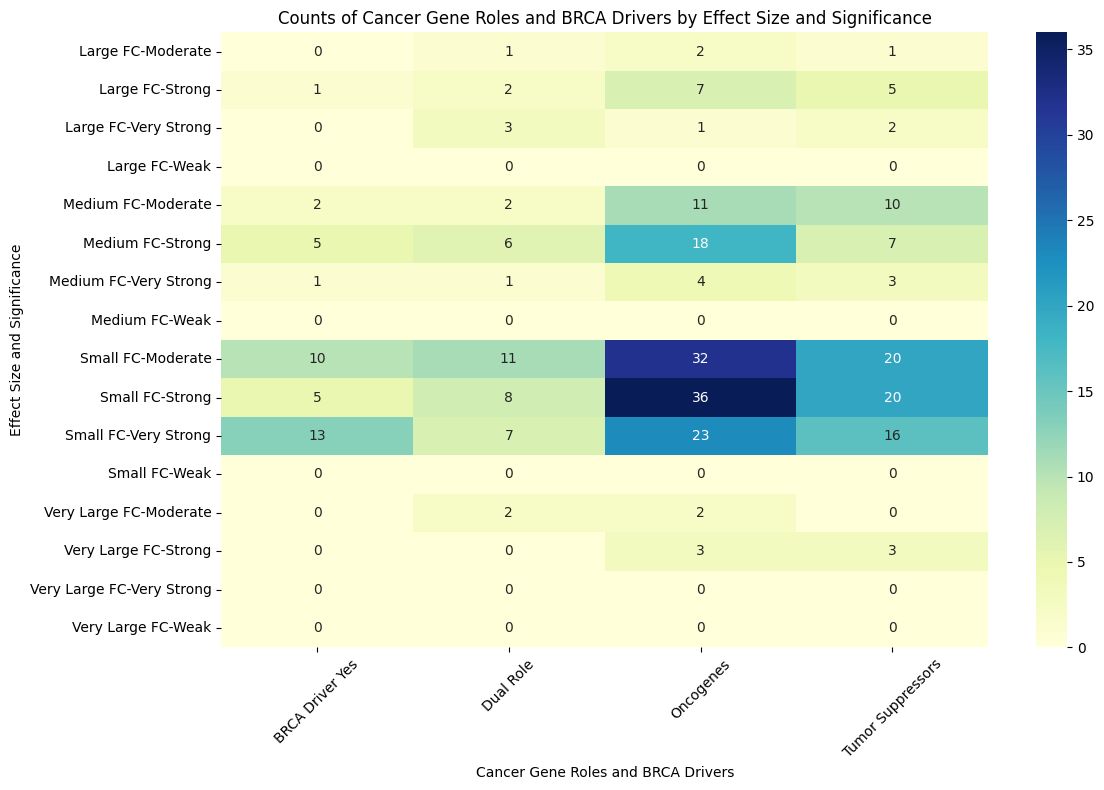

In [5]:
df_significant = df[df.is_significant].copy()

# Add interpretation columns
df_significant['effect_size'] = pd.cut(abs(df_significant['log2fc']), 
    bins=[-np.inf, 0.5, 1, 2, np.inf],
    labels=['Small FC', 'Medium FC', 'Large FC' , 'Very Large FC'])

df_significant['significance'] = pd.cut(df_significant['max_abs_z'],
    bins=[-np.inf, 2, 5, 10, np.inf],
    labels=['Weak', 'Moderate', 'Strong', 'Very Strong'])

# Look at distribution
pd.crosstab(df_significant['effect_size'], df_significant['significance'])


# Initialize a list to store results
results_list = []

# Define the combinations of effect size and significance
effect_sizes = ['Small FC', 'Medium FC', 'Large FC', 'Very Large FC']
significances = ['Weak', 'Moderate', 'Strong', 'Very Strong']

# Loop through each combination
for effect in effect_sizes:
    for significance in significances:
        # Filter significant genes based on current effect size and significance
        filtered_genes = df_significant[(df_significant.effect_size == effect) & (df_significant.significance == significance)]
        
        # Count cancer gene roles
        cancer_role_counts = filtered_genes.cancer_gene_role.value_counts()
        
        # Count BRCA drivers
        brca_driver_count = filtered_genes['is_brca_driver'].value_counts()

        # Prepare row data
        result_row = {
            'Effect Size': effect,
            'Significance': significance,
            'Total Genes': filtered_genes.shape[0],
            'Oncogenes': cancer_role_counts.get('oncogene', 0),
            'Tumor Suppressors': cancer_role_counts.get('tumor_suppressor', 0),
            'Dual Role': cancer_role_counts.get('dual_role', 0),
            # 'Neither': cancer_role_counts.get('neither', 0),
            'BRCA Driver Yes': brca_driver_count.get(True, 0),
            # 'BRCA Driver No': brca_driver_count.get(False, 0)
        }
        
        results_list.append(result_row)

# Create DataFrame
results_df = pd.DataFrame(results_list)

# Prepare data for heatmap
heatmap_data = results_df.melt(id_vars=['Effect Size', 'Significance'],
                                 value_vars=['Oncogenes', 'Tumor Suppressors', 
                                             'Dual Role', 
                                             'BRCA Driver Yes'],
                                 var_name='Role', value_name='Count')

# Create a pivot table
heatmap_pivot = heatmap_data.pivot_table(index=['Effect Size', 'Significance'], 
                                           columns='Role', 
                                           values='Count',
                                           fill_value=0)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Counts of Cancer Gene Roles and BRCA Drivers by Effect Size and Significance')
plt.xlabel('Cancer Gene Roles and BRCA Drivers')
plt.ylabel('Effect Size and Significance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
def plot_mutation_signatures(data, title, figsize=(12, 6)):
    """
    Create a bar plot of mutation signature distribution.
    
    Args:
        data: DataFrame containing mutation signature data
        figsize: Tuple specifying figure dimensions (width, height)
    """
    # Create figure and axis
    plt.figure(figsize=figsize)
    
    # Create countplot with updated syntax
    ax = sns.countplot(
        x='mutsig',
        hue='mutsig',  # Add hue parameter
        data=data,
        order=data.mutsig.value_counts().index,
        palette='viridis',
        legend=False  # Hide legend since it's redundant
    )
    
    # Set titles and labels
    ax.set_title(title, 
                 fontsize=15, pad=20)
    ax.set_xlabel('Mutation Signature', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on bars
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(
            f'{int(height)}',
            xy=(bar.get_x() + bar.get_width()/2., height),
            ha='center',
            va='bottom',
            xytext=(0, 5),
            textcoords='offset points'
        )
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    

def plot_stacked_mutation_signatures(df_tsupps, df_oncogenes, figsize=(12, 8)):

    # Prepare data
    df_tsupps['gene_type'] = 'Tumor Suppressors'
    df_oncogenes['gene_type'] = 'Oncogenes'
    df_combined = pd.concat([df_tsupps, df_oncogenes])
    
    # Get order of mutation signatures by total count
    order = df_combined['mutsig'].value_counts().index

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create stacked bar plot
    sns.countplot(
        x='mutsig',
        hue='gene_type',
        data=df_combined,
        order=order,
        palette='viridis'
    )
    
    # Set titles and labels
    ax.set_title('Mutation Signature Distribution: Downregulated Tumor Suppressors vs Upregulated Oncogenes', 
                 fontsize=15, pad=20)
    ax.set_xlabel('Mutation Signature', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    # Alternative with more formatting options
    for container in ax.containers:
        ax.bar_label(container, 
                    label_type='center',
                    fontsize=8,
                    weight='light',  # Makes the font lighter
                    color='black')   # Changes text color

    # Adjust layout
    plt.legend(title='Gene Type', loc='upper right')
    plt.tight_layout()
    plt.show()


In [7]:
df_significant_oncogenes = df_significant[df_significant['is_oncogene_consensus'] == True]
df_significant_oncogenes

,gene_id,upreg_count_real,downreg_count_real,upreg_count_synth,downreg_count_synth,upreg_synth_norm,downreg_synth_norm,log2fc_new_sites,log2fc_lost_sites,z_score_new_sites,z_score_lost_sites,pvalue,adjusted_pvalue,log2fc,is_significant,strong_new_sites,strong_lost_sites,is_one_way,significant_upreg,significant_downreg,is_brca_driver,is_oncogene_consensus,is_tsupp_consensus,cancer_gene_role,max_abs_z,effect_size,significance
76,ENSG00000005073,80,1,596,81,59.6,8.1,-3.017922,0.424688,-2.494686,2.642452,4.813407e-03,1.258903e-02,3.442610,True,True,True,False,True,False,False,True,True,dual_role,2.642452,Very Large FC,Moderate
91,ENSG00000005339,2372,1021,23373,9562,2337.3,956.2,0.094599,0.021261,2.095563,0.717748,1.814395e-02,4.264441e-02,-0.073337,True,True,False,True,False,True,True,True,True,dual_role,2.095563,Small FC,Moderate
140,ENSG00000006468,2051,714,15620,9073,1562.0,907.3,-0.345656,0.392933,-6.417360,12.372810,0.000000e+00,0.000000e+00,0.738589,True,True,True,False,True,False,True,True,False,oncogene,12.372810,Medium FC,Very Strong
373,ENSG00000017427,2248,581,17463,6228,1746.3,622.8,-0.100231,0.364341,-1.674951,12.005622,0.000000e+00,0.000000e+00,0.464571,True,False,True,True,True,False,False,True,False,oncogene,12.005622,Small FC,Very Strong
395,ENSG00000019991,1726,701,15769,6679,1576.9,667.9,0.069782,0.130341,1.280773,3.754703,1.019646e-04,3.586160e-04,0.060559,True,False,True,True,True,False,False,True,False,oncogene,3.754703,Small FC,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18103,ENSG00000213231,71,85,529,630,52.9,63.0,0.432111,0.424551,2.771739,2.488575,3.394791e-03,9.156232e-03,-0.007560,True,True,True,False,True,True,False,True,False,oncogene,2.771739,Small FC,Moderate
18471,ENSG00000214827,771,179,7158,2328,715.8,232.8,-0.379131,0.107174,-3.526069,2.063209,1.960916e-02,4.577565e-02,0.486306,True,True,True,False,True,False,False,True,False,oncogene,3.526069,Small FC,Moderate
24981,ENSG00000244405,1364,549,15098,4752,1509.8,475.2,0.208271,-0.146514,3.385464,-3.752302,4.305461e-04,1.360877e-03,-0.354785,True,True,True,False,False,True,False,True,False,oncogene,3.752302,Small FC,Moderate
26402,ENSG00000251562,455,185,3413,1292,341.3,129.2,0.517919,0.414826,4.909112,6.154494,1.976834e-09,1.317749e-08,-0.103093,True,True,True,False,True,True,False,True,True,dual_role,6.154494,Small FC,Strong
